#### Things to try to improve acc.
1. Change Dense activation functions
2. More data
3. More layers
4. Change loss function
5. Change optimizer
6. Give time
7. Check if data is correctly labeled

In [1]:
%matplotlib inline

from __future__ import print_function
import keras
import numpy as np
import pickle 

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Merge
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras import backend as K
from keras.utils import plot_model
from cv2 import imread

from matplotlib import pyplot as plt
from IPython.display import clear_output

from old_data import getVideoData
from old_data import getAudioData
from old_data import getFusionData

Using TensorFlow backend.


## Utility functions
#### Plotting Errors
#### Saving and Loading

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

def saveWeights(model, fname):
    model.save_weights(fname)

def loadModel(fname):
    model = fusedMain()
    model.load_weights(fname)
    return model

In [3]:
def getModelArchitecture(input_shape, final_pool):
    cmodel = Sequential()

    #cmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding = 'same'))
    cmodel.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding = 'same'))
    #cmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cmodel.add(Dropout(0.25))

    cmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    #cmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cmodel.add(Dropout(0.25))

    #cmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    #cmodel.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cmodel.add(Dropout(0.25))

    #cmodel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    #cmodel.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    cmodel.add(MaxPooling2D(pool_size=(final_pool), strides=None, padding='same'))
    cmodel.add(Dropout(0.25))

#    cmodel.add(Flatten())
#    cmodel.add(Dense(32, activation='sigmoid'))
#    cmodel.add(Dropout(0.25))
#    cmodel.add(Dense(2, activation='sigmoid'))

    return cmodel

#testing
getModelArchitecture((224, 224, 3), (28, 28)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
__________

## Code for building submodels.

In [4]:
def vidMain():
    model = getModelArchitecture((224, 224, 3), (28, 28))
    model = addFCLayers(model)
    model = getTrainedModel(model, dataFactory = getVideoData)

    return model

def audioMain():
    model = getModelArchitecture((199, 257, 3), (25, 33))
    model = addFCLayers(model)
    model = getTrainedModel(model, dataFactory = getAudioData)

## Fusion branch

In [5]:
def fusionBranch(video_branch, audio_branch):

    final = Sequential()
    final.add(Merge([video_branch, audio_branch]))
    final.add(Dense(512, activation='sigmoid'))
    final.add(Dense(128, activation='sigmoid'))
    final.add(Flatten())
    final.add(Dense(1, activation='sigmoid'))

    final.compile(loss='mse',
            #optimizer=keras.optimizers.Adadelta(),
            optimizer='adam',
            metrics=['accuracy']
            )


    return final

In [6]:
def trainFinal(final):
    print('Getting data...')
    audio_video_data_tuple, label_on_correspondence, test_data, test_labels= getFusionData()
    print('Data ready')

    final.fit(audio_video_data_tuple, label_on_correspondence,
            batch_size=10, epochs=100, verbose=1, callbacks=[plot_losses],
             validation_data=(test_data, test_labels))
              
    print(final.evaluate(test_data, test_labels, verbose=1))

    return final

## Main

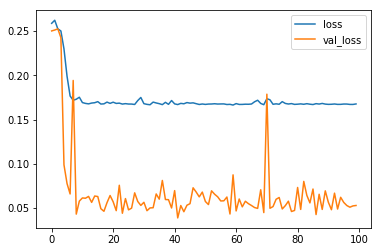

200/200 [==============================] - 0s     
[0.052946923367258023, 1.0]


In [7]:
def fusedMain():
    vmodel = getModelArchitecture((224, 224, 3), (28, 28))
    amodel = getModelArchitecture((199, 257, 3), (25, 33))
    
    f = fusionBranch(vmodel, amodel)

    return f

if __name__ == '__main__':
    f = fusedMain()
    f = trainFinal(f)
    saveWeights(f, 'model.h5')

### Test code below for sub-model training.

In [8]:
def addFCLayers(cmodel):

    cmodel.add(Flatten())
    cmodel.add(Dense(32, activation='sigmoid'))
    cmodel.add(Dropout(0.25))
    cmodel.add(Dense(2, activation='sigmoid'))

    return cmodel
    

def trainModel(model, x_train, y_train, x_test, y_test):
    model.compile(loss='categorical_crossentropy', 
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

    model.fit(x_train, y_train, 
            batch_size=8,
            verbose=1,
            validation_data=(x_test, y_test))

    return model